In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

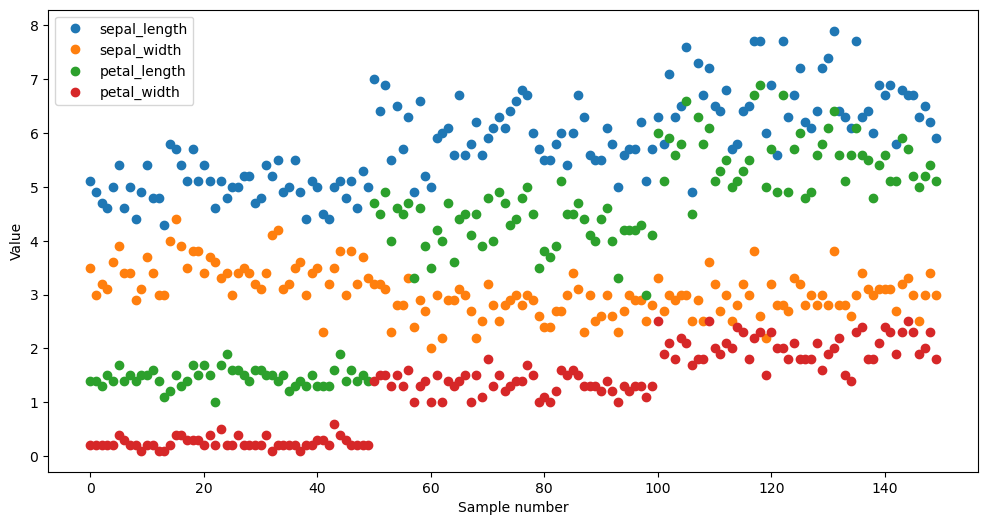

In [3]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [4]:
####   ------------------------------- < NOTE ABOUT THIS CELL!!! > ---------------------------------------   ####
#                                                                                                               #
# The code here is intentionally commented out. We're going to use this in the lecture "The importance of       #
# data standardization" in the next section. If you're not doing that lecture, leave this commented! Thanks!    #
#                                                                                                               #
####   ------------------------------- </ NOTE ABOUT THIS CELL!!! > --------------------------------------   ####


# # z-score the data
# import scipy.stats as stats
# cols2zscore = iris.keys()
# cols2zscore = cols2zscore.drop('species')
# iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

# iris.plot(marker='o',linestyle='none',figsize=(12,6))
# plt.xlabel('Sample number')
# plt.ylabel('Value')
# plt.show()

In [5]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [6]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

In [7]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


# Construct the model and training plans

In [8]:
# Define a function that creates the architecture of an Artificial Neural Network (ANN) model.
def createANewModel():

  # Define the model architecture using nn.Sequential.
  ANNiris = nn.Sequential(
      nn.Linear(4, 64),   # Input layer: 4 input features, 64 output features (neurons)
      nn.ReLU(),          # Activation function: ReLU (Rectified Linear Unit)
      nn.Linear(64, 64),  # Hidden layer: 64 input features, 64 output features
      nn.ReLU(),          # Activation function: ReLU
      nn.Linear(64, 3),   # Output layer: 64 input features, 3 output features (for classification)
  )

  # Define the loss function for classification problems.
  lossfun = nn.CrossEntropyLoss()

  # Define the optimizer for training the model.
  # Here, stochastic gradient descent (SGD) is used with a learning rate of 0.0005.
  optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.0005)

  # Return the created ANN model, loss function, and optimizer.
  return ANNiris, lossfun, optimizer


In [9]:
# Define a function that trains the ANN model.

# Set a global parameter for the number of training epochs.
numepochs = 2500

def trainTheModel():

  # Initialize lists to store training accuracies, test accuracies, and losses.
  trainAcc = []
  testAcc  = []
  losses   = []

  # Loop over training epochs.
  for epochi in range(numepochs):

    # Initialize lists to store batch accuracies and batch losses.
    batchAcc  = []
    batchLoss = []

    # Loop over training data batches.
    for X, y in train_loader:

      # Forward pass: compute predicted labels (yHat) and calculate the loss.
      yHat = ANNiris(X)
      loss = lossfun(yHat, y)
      
      # Backpropagation: zero gradients, calculate gradients, and update model weights.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch.
      batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
      batchLoss.append(loss.item())

    # End of batch loop...

    # Calculate the average training accuracy and average loss for this epoch.
    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))

    # Test accuracy: Evaluate the model's performance on the test data.
    X, y = next(iter(test_loader))  # Extract X and y from the test dataloader.
    predlabels = torch.argmax(ANNiris(X), axis=1)
    testAcc.append(100 * torch.mean((predlabels == y).float()).item())

  # Function output: Lists of training accuracies, test accuracies, and losses over epochs.
  return trainAcc, testAcc, losses



# Test it out

In [10]:
# Create an ANN model, specify the loss function, and optimizer.

# Create the ANN model using the createANewModel function.
ANNiris, lossfun, optimizer = createANewModel()

# Train the model using the trainTheModel function.
trainAcc, testAcc, losses = trainTheModel()


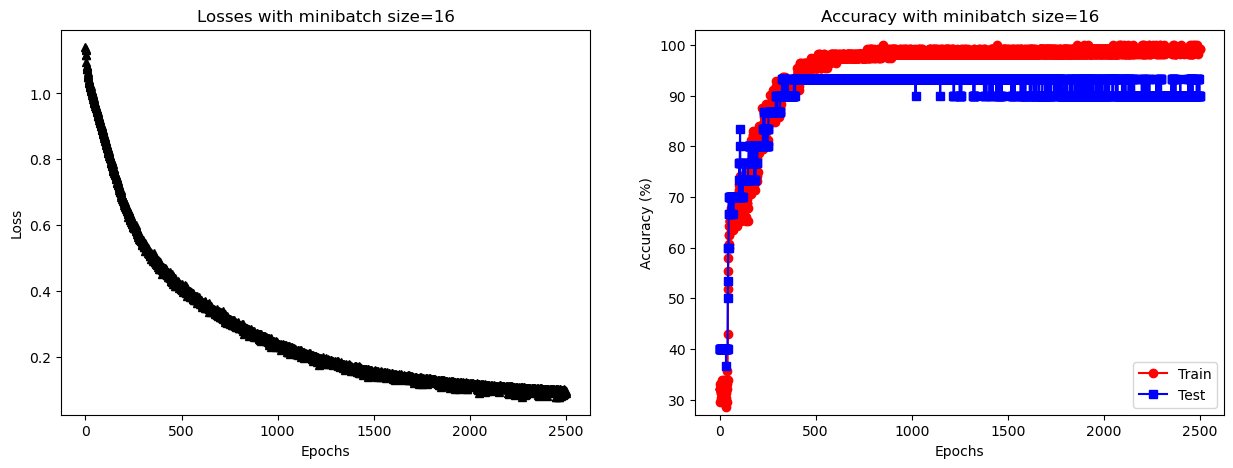

In [11]:
# Create a figure with two subplots (1 row, 2 columns) for displaying the results.
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the losses over epochs in the first subplot.
ax[0].plot(losses, 'k^-')  # 'k^-': Black color with triangles as markers
ax[0].set_ylabel('Loss')  # Label for the y-axis
ax[0].set_xlabel('Epochs')  # Label for the x-axis
ax[0].set_title('Losses with minibatch size=' + str(batchsize))  # Title for the subplot

# Plot the training and test accuracies over epochs in the second subplot.
ax[1].plot(trainAcc, 'ro-')  # 'ro-': Red color with circles as markers
ax[1].plot(testAcc, 'bs-')  # 'bs-': Blue color with squares as markers
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))  # Title for the subplot
ax[1].set_xlabel('Epochs')  # Label for the x-axis
ax[1].set_ylabel('Accuracy (%)')  # Label for the y-axis
ax[1].legend(['Train', 'Test'])  # Legend to differentiate between training and test accuracy
ax[1].set_ylim([27, 103])  # Set the y-axis limits for better visualization

# Display the plot.
plt.show()


# Additional explorations

In [12]:
# 1) Is there a relationship between the test_size parameter in train_test_split(), the batchsize parameter in DataLoader,
#    and the length of test_data? Think of your answer first, then test it in code, by creating new dataloader objects 
#    with varying test_size parameters.
#    Hint: You can use the code 'len(test_data.dataset.tensors[1])', which returns the length of the labels vector.
# 
# 2) Let's say you didn't care about the three types of irises; you only want a model that labels a flower as setosa or 
#    "other." What would you have to change in the data and in the model to make this work?
# 
# 3) In the course section "More on data," you will learn that unbalanced designs can be problematic for DL models (an
#    unbalanced design means that there is an uneven distribution of samples in different categories). Does the 
#    modification in #2 produce an unbalanced design? To find out, count the number of data labels that are 0 (setosa) or
#    1 (not setosa).
# 